In [1]:
%load_ext autoreload
%autoreload 2

from tools import *
from models import *

from keras import optimizers
from keras.models import load_model
from keras.callbacks import *
import keras

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
import os
import random

tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
X_train, y_train, y_train_steer = load_data()

print(f"Images: {len(X_train)}")
print(f"Controls: {len(y_train)}")
print(f"Steers: {len(y_train_steer)}\n")

steer_count = 0
for steer in y_train_steer:
    steer_count += steer.item()
print(f"Should Steers: {steer_count}")

input_shape = X_train[0].shape
print("Input shape: " + str(input_shape))

Loading data

Finished loading data

Images: 3681
Controls: 3681
Steers: 3681

Should Steers: 1878
Input shape: (120, 160, 3)


Frame: 1104
Control: [-0.0068]
Steer: [1]


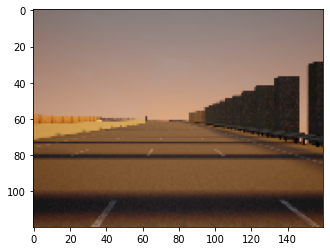

In [3]:
FRAME = random.randint(1, 2000)

show_image(X_train[FRAME])
print(f"Frame: {FRAME}")
print(f"Control: {y_train[FRAME]}")
print(f"Steer: {y_train_steer[FRAME]}")

In [4]:
# Stops training early when no improvement for monitor value
early_stop = EarlyStopping(monitor="loss", 
                           min_delta=0, 
                           patience=5, 
                           verbose=1)

# Reduces learning rate when monitor value plateaus
reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.316, 
                              patience=3, 
                              verbose=1)

cb_list = [early_stop, reduce_lr]

In [5]:
keras.backend.clear_session()

# model = ImiCarla(input_shape=input_shape)
steer_model = ImiSteer(input_shape=input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 160, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 160, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 160, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 80, 32)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 80, 64)        2

In [6]:
steer_optim = optimizers.Adam(learning_rate=0.001)
steer_model.compile(steer_optim, loss="binary_crossentropy", metrics=["accuracy"])

In [7]:
steer_history = steer_model.fit(x=X_train, 
                                y=y_train_steer, 
                                batch_size=16, 
                                epochs=50, 
                                verbose=2, 
                                validation_split=0.05, 
                                shuffle=True, 
                                callbacks=cb_list)

Epoch 1/50
219/219 - 4s - loss: 0.6611 - accuracy: 0.6885 - val_loss: 0.5215 - val_accuracy: 0.7892
Epoch 2/50
219/219 - 4s - loss: 0.5096 - accuracy: 0.7606 - val_loss: 0.5334 - val_accuracy: 0.7189
Epoch 3/50
219/219 - 4s - loss: 0.4748 - accuracy: 0.7918 - val_loss: 0.4114 - val_accuracy: 0.8000
Epoch 4/50
219/219 - 4s - loss: 0.4455 - accuracy: 0.8072 - val_loss: 0.3422 - val_accuracy: 0.8541
Epoch 5/50
219/219 - 4s - loss: 0.4131 - accuracy: 0.8318 - val_loss: 0.3282 - val_accuracy: 0.8649
Epoch 6/50
219/219 - 4s - loss: 0.4039 - accuracy: 0.8398 - val_loss: 0.2723 - val_accuracy: 0.8919
Epoch 7/50
219/219 - 4s - loss: 0.3994 - accuracy: 0.8324 - val_loss: 0.3954 - val_accuracy: 0.8486
Epoch 8/50
219/219 - 4s - loss: 0.3849 - accuracy: 0.8464 - val_loss: 0.3766 - val_accuracy: 0.8703
Epoch 9/50

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0003160000150091946.
219/219 - 4s - loss: 0.3769 - accuracy: 0.8521 - val_loss: 0.3324 - val_accuracy: 0.8757
Epoch 10/50
219/219

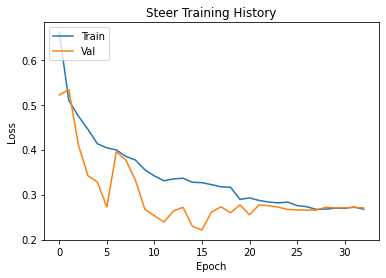

In [8]:
plt.plot(steer_history.history["loss"])
plt.plot(steer_history.history["val_loss"])
plt.title("Steer Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

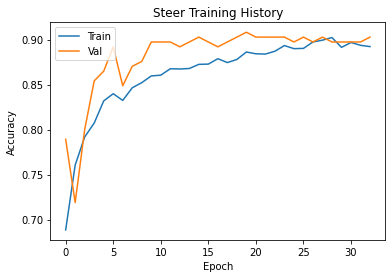

In [9]:
plt.plot(steer_history.history["accuracy"])
plt.plot(steer_history.history["val_accuracy"])
plt.title("Steer Training History")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [10]:
STEER_MODEL_PATH = "ImiSteer.h5"
steer_model.save(STEER_MODEL_PATH)

In [11]:
loaded_steer_model = load_model(STEER_MODEL_PATH, compile=True)

In [12]:
NUM_SAMPLES = 6

for _ in range(NUM_SAMPLES):
    FRAME = random.randint(1, len(X_train))
    y_pred = loaded_steer_model.predict(x=np.array([X_train[FRAME]]), batch_size=None)

    print(f"Frame: {FRAME}")
    print(f"Prediction: {y_pred}")
    print(f"Actual: {y_train_steer[FRAME]}\n")

Frame: 678
Prediction: [[0.9663149]]
Actual: [1]

Frame: 1473
Prediction: [[0.93556195]]
Actual: [1]

Frame: 122
Prediction: [[0.07123517]]
Actual: [0]

Frame: 1700
Prediction: [[0.11420874]]
Actual: [0]

Frame: 876
Prediction: [[0.19116223]]
Actual: [0]

Frame: 3184
Prediction: [[0.9909862]]
Actual: [1]



# ============================================================

In [13]:
X_train_control = []
y_train_control = []

for i in range(len(y_train_steer)):
    if y_train_steer[i] == 1:
        X_train_control.append(X_train[i])
        y_train_control.append(y_train[i])
        
print(f"Control points: {len(X_train_control)}")
assert steer_count == len(X_train_control)

Control points: 1878


In [14]:
keras.backend.clear_session()

model = ImiCarla(input_shape=input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 160, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 160, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 160, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 80, 32)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 80, 64)        2

In [15]:
optim = optimizers.Adam(learning_rate=0.001)
model.compile(optim, loss="mean_absolute_error")

In [16]:
history = model.fit(x=np.array(X_train_control), 
                    y=np.array(y_train_control), 
                    batch_size=16, 
                    epochs=50, 
                    verbose=2, 
                    validation_split=0.05, 
                    shuffle=True, 
                    callbacks=cb_list)

Epoch 1/50
112/112 - 2s - loss: 0.8386 - val_loss: 5.8755
Epoch 2/50
112/112 - 2s - loss: 0.3158 - val_loss: 0.2080
Epoch 3/50
112/112 - 2s - loss: 0.2242 - val_loss: 0.5695
Epoch 4/50
112/112 - 2s - loss: 0.1769 - val_loss: 0.1142
Epoch 5/50
112/112 - 2s - loss: 0.1418 - val_loss: 0.0470
Epoch 6/50
112/112 - 2s - loss: 0.1140 - val_loss: 0.0676
Epoch 7/50
112/112 - 2s - loss: 0.0960 - val_loss: 0.0222
Epoch 8/50
112/112 - 2s - loss: 0.0852 - val_loss: 0.0223
Epoch 9/50
112/112 - 2s - loss: 0.0686 - val_loss: 0.0313
Epoch 10/50
112/112 - 2s - loss: 0.0690 - val_loss: 0.0212
Epoch 11/50
112/112 - 2s - loss: 0.0554 - val_loss: 0.0170
Epoch 12/50
112/112 - 2s - loss: 0.0534 - val_loss: 0.0349
Epoch 13/50
112/112 - 2s - loss: 0.0518 - val_loss: 0.0104
Epoch 14/50
112/112 - 2s - loss: 0.0449 - val_loss: 0.0164
Epoch 15/50
112/112 - 2s - loss: 0.0422 - val_loss: 0.0398
Epoch 16/50
112/112 - 2s - loss: 0.0406 - val_loss: 0.0095
Epoch 17/50
112/112 - 2s - loss: 0.0322 - val_loss: 0.0146
Epoch 

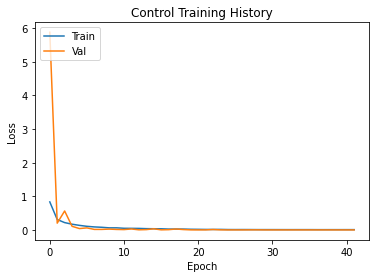

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Control Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [18]:
MODEL_PATH = "ImiCarla.h5"
model.save(MODEL_PATH)

In [19]:
loaded_model = load_model(MODEL_PATH, compile=True)

In [20]:
NUM_SAMPLES = 6

for _ in range(NUM_SAMPLES):
    FRAME = random.randint(1, len(X_train_control))
    y_pred = loaded_model.predict(x=np.array([X_train_control[FRAME]]), batch_size=None)

    print(f"Frame: {FRAME}")
    print(f"Prediction: {y_pred}")
    print(f"Actual: {y_train_control[FRAME]}\n")

Frame: 947
Prediction: [[0.06264371]]
Actual: [0.08666]

Frame: 1108
Prediction: [[0.03683466]]
Actual: [0.02804]

Frame: 1665
Prediction: [[-0.02176173]]
Actual: [-0.02788]

Frame: 825
Prediction: [[0.02816018]]
Actual: [0.01906]

Frame: 711
Prediction: [[-0.0200767]]
Actual: [-0.02362]

Frame: 1560
Prediction: [[-0.0234744]]
Actual: [-0.00772]

